In [2]:
import numpy as np

def w(i, k, t, x):
    ii=i-1 # re-index to account for python array indexing
    
    if not t[ii]==t[ii+k-1]:
        return (x-t[ii]) / (t[ii+k-1]-t[ii])
    else:
        return 0.0
    
def bspline(i, k, t, x):
    '''
    B_{i,k} (x) on extended knot sequence t (t1, ...., tq)
    where k is the order of the spline
    i is the index of the basis (1...q + p -1)
    where q is len(original_knot sequence)
    p = k-1 (degree of spline)
    
    in order to cope with python indexing will internally shift all indices by 1
    '''
    ii = i-1 # re-index to account for python array indexing
    
    if k==1:
        # piecewise constant
        if t[ii]<=x and x<t[ii+1]:
            return 1.
        else:
            return 0.
        
    else:
        c1 = w(i, k, t, x)
        c2 = 1.-w(i+1, k, t, x)
        return c1 * bspline(i, k-1, t, x) + c2 * bspline(i+1, k-1, t, x) 

In [3]:
p = 3 # spline degree
k = p+1 # spline order

t_orig = np.array([0.0, 0.5, 1.5, 3.5, 4.0])
q = len(t_orig)

# extend knots
t0 = np.ones(p) * t_orig[0]
t1 = np.ones(p) * t_orig[-1]
t = np.concatenate((t0, t_orig, t1), axis=None)

# coefficients
N = q+p-1
c = np.ones(N) + np.random.normal(0.0, 0.3, N)

In [4]:
# plot basis
from matplotlib import pyplot as plt

yvals_arr = []
for idx in range(N):
    idx_curr = idx+1 # re-index to account B-spline indexing
    xvals = np.linspace(t[0],t[-1],1000)
    yvals = np.asarray([bspline(idx_curr, k, t, tx) for tx in xvals])
    yvals_arr.append(yvals)
    plt.plot(xvals, yvals, 'k--')
    
# now plot a superposition
yvals = 0
for obj in zip(c, yvals_arr):
    tc, ty = obj
    yvals+=tc * ty
    
print "coefficients:",c
plt.plot(xvals, yvals, 'r-')

coefficients: [0.61307724 1.05175444 0.97650047 0.40268474 1.67018471 0.80915929
 0.83331999]


coefficients [-7.40096878  6.60751404 -7.8123763   8.16091583]
knots [-2.  2.]


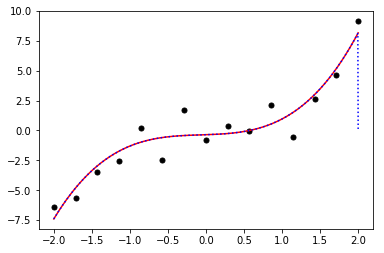

In [5]:
# now check consistency with scipy interpolate
# generate fake data - with noise
np.random.seed(1)

xmin = -2.
xmax = 2.
xobs = np.linspace(xmin, xmax, 15)
stderr = 1.0
yobs = xobs**3+np.random.normal(0.0, stderr, len(xobs))

# now interpolate with scipy
from scipy.interpolate import UnivariateSpline
func = UnivariateSpline(xobs, yobs, s=30, k=p) # scipy denotes degree of spline with k (meh!)
new_x = np.linspace(xmin, xmax, 1000)
new_y = func(new_x)
plt.figure()
plt.plot(xobs, yobs, ".", markersize=10, color='black')
plt.plot(new_x,new_y, "r-")

# now run my own code
print "coefficients", func.get_coeffs()
print "knots", func.get_knots()

t_orig = func.get_knots()
q = len(t_orig)

t0 = np.ones(p) * t_orig[0]
t1 = np.ones(p) * t_orig[-1]
t = np.concatenate((t0, t_orig, t1), axis=None)

# coefficients
N = q+p-1
c = func.get_coeffs()

yvals_arr = []
for idx in range(N):
    idx_curr = idx+1 # re-index to account B-spline indexing
    xvals = np.linspace(t[0],t[-1],1000)
    yvals = np.asarray([bspline(idx_curr, k, t, tx) for tx in new_x])
    yvals_arr.append(yvals)
    
# now plot a superposition
yvals = 0
for obj in zip(c, yvals_arr):
    tc, ty = obj
    yvals+=tc * ty
    
plt.plot(xvals, yvals, 'b', linestyle='dotted')

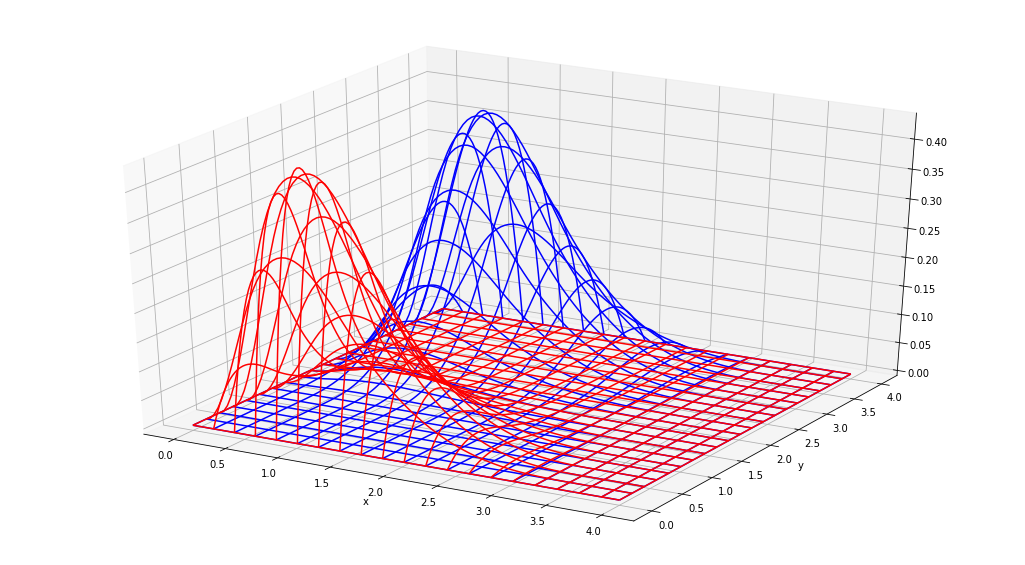

In [6]:
# lets see if we can repeat this in 2D 
from mpl_toolkits.mplot3d import Axes3D

# lets first build a tensor product spline

# we start one dimensional as before
p = 3 # spline degree
k = p+1 # spline order

tx_orig = np.array([0.0, 0.5, 1.5, 3.5, 4.0])
ty_orig = np.array([0.0, 1.0, 2.5, 4.0])
qx = len(tx_orig)
qy = len(ty_orig)

# extend knots
tx0 = np.ones(p) * tx_orig[0]
tx1 = np.ones(p) * tx_orig[-1]
tx = np.concatenate((tx0, tx_orig, tx1), axis=None)

ty0 = np.ones(p) * ty_orig[0]
ty1 = np.ones(p) * ty_orig[-1]
ty = np.concatenate((ty0, ty_orig, ty1), axis=None)
# coefficients
Nx = qx+p-1
Ny = qy+p-1

# now plot one basis element
idx_x = 3
idx_y = 2

xaxis = np.linspace(tx[0], tx[-1], 100)
yaxis = np.linspace(ty[0], ty[-1], 100)
xx, yy = np.meshgrid(xaxis, yaxis)
xx=xx.T
yy=yy.T
z = []
for ti in range(len(xx)):
    z_temp =[]
    for tj in range(len(xx[0])):
        currx = xx[ti][tj]
        curry = yy[ti][tj]
        z_temp.append(bspline(idx_x, k, tx, currx) * bspline(idx_y, k, ty, curry))
    z.append(z_temp)

z = np.asarray(z)
fig = plt.figure(figsize=(18, 10))
ax = fig.add_subplot(111, projection='3d')
surf = ax.plot_wireframe(xx, yy, z, rstride=5, cstride=5, color='red')


# and another basis element
idx_x = 3
idx_y = 5

xaxis = np.linspace(tx[0], tx[-1], 100)
yaxis = np.linspace(ty[0], ty[-1], 100)
xx, yy = np.meshgrid(xaxis, yaxis)
xx=xx.T
yy=yy.T
z = []
for ti in range(len(xx)):
    z_temp =[]
    for tj in range(len(xx[0])):
        currx = xx[ti][tj]
        curry = yy[ti][tj]
        z_temp.append(bspline(idx_x, k, tx, currx) * bspline(idx_y, k, ty, curry))
    z.append(z_temp)

z = np.asarray(z)
surf = ax.plot_wireframe(xx, yy, z, rstride=5, cstride=5, color='blue')

ax.set_xlabel('x')
ax.set_ylabel('y')

  
# values taken from scipy.RectBivariateSpline fit to Aeff for NuE_CC events

coeffs = np.array([-3.58077707, -3.41361407, -3.67857551, -4.18870088, -4.33580191, -1.96090326,
 -1.97689,    -2.05099873, -2.14549395, -2.17675871, -0.34077015, -0.32737177,
 -0.30599357, -0.29709922, -0.29278352,  0.48041494,  0.94140028,  1.02319478,
  0.88547053,  0.95448815, -0.26299716,  0.99602738,  1.47548988,  1.31308221,
  1.42759428, -1.33184261,  0.47994404,  1.74747881,  1.44319947,  1.39107924])

tx = np.array([2.90998783, 2.90998783, 2.90998783, 2.90998783, 4.03010253,
       5.00991847, 6.96995941, 6.96995941, 6.96995941, 6.96995941])

ty = np.array([-0.9, -0.9, -0.9, -0.9,  0.1,  0.9,  0.9,  0.9,  0.9])

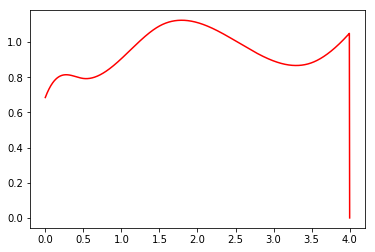

In [2]:
import numpy as np
from matplotlib import pyplot as plt
from bspline_ev import bspline_basis, bspline_func_1d
p = 3 # spline degree
t_orig = np.array([0.0, 0.5, 1.5, 3.5, 4.0]) # knot sequence
N = len(t_orig)+p-1 # number of coefficients that need to be defined
c = np.ones(N) + np.random.normal(0.0, 0.3, N) # random coefficients

func = bspline_func_1d(t_orig, p, c)
x = np.linspace(0.0, 4.0, 1000)
y = np.asarray([func.eval(tx) for tx in x])
plt.plot(x,y,"r-")

Text(0.5,0,'y')

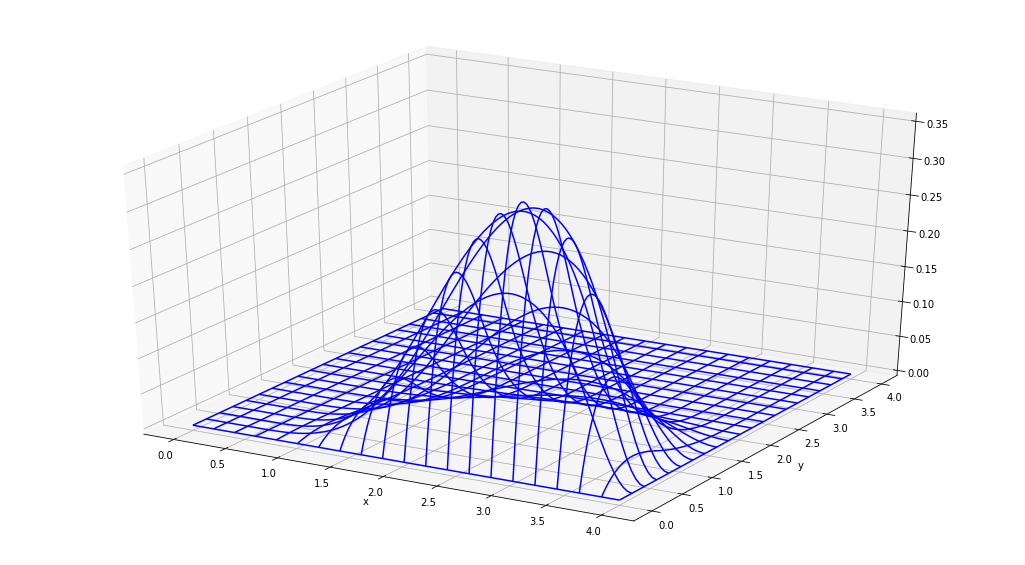

In [16]:
import numpy as np
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from bspline_ev import bspline_func_2d

p = 3 # spline degree
tx_orig = np.array([0.0, 0.5, 1.5, 3.5, 4.0]) # knot sequence
ty_orig = np.array([0.0, 1.0, 2.5, 4.0]) # knot sequence
Nx = len(tx_orig)+p-1 # number of coefficients that need to be defined
Ny = len(ty_orig)+p-1 # number of coefficients that need to be defined
N = Nx * Ny

c = np.zeros(N) 
c[25]=1 # all coefficients zero except for one
#c = np.ones(N) + np.random.normal(0.0, 0.3, N) # random coefficient
c = c.reshape(Nx, Ny)
func = bspline_func_2d(tx_orig, ty_orig, p, c)


#print func.eval(2.0, 2.0)


xaxis = np.linspace(tx_orig[0], tx_orig[-1], 100)
yaxis = np.linspace(ty_orig[0], ty_orig[-1], 100)

z = np.asarray([func.eval(tx, ty) for tx in xaxis for ty in yaxis])
z = z.reshape(len(xaxis), len(yaxis))

xx, yy = np.meshgrid(xaxis, yaxis)
xx=xx.T
yy=yy.T

fig = plt.figure(figsize=(18, 10))
ax = fig.add_subplot(111, projection='3d')
surf = ax.plot_wireframe(xx, yy, z, rstride=5, cstride=5, color='blue')

ax.set_xlabel('x')
ax.set_ylabel('y')


Text(0.5,0,'y')

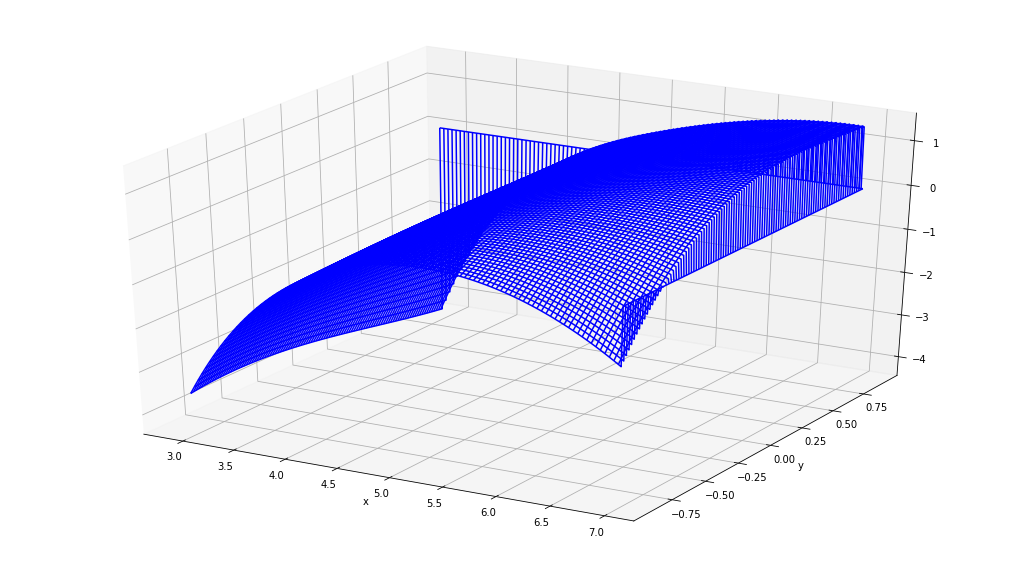

In [3]:
import numpy as np
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from bspline_ev import bspline_func_2d

p = 3 # spline degree
tx_orig = np.array([2.90998783, 4.03010253, 5.00991847, 6.96995941]) # knot sequence
ty_orig = np.array([-0.9,  0.1,  0.9]) # knot sequence
Nx = len(tx_orig)+p-1 # number of coefficients that need to be defined
Ny = len(ty_orig)+p-1 # number of coefficients that need to be defined
N = Nx * Ny


c = np.asarray([-3.58077707, -3.41361407, -3.67857551, -4.18870088, -4.33580191, -1.96090326,
 -1.97689,    -2.05099873, -2.14549395, -2.17675871, -0.34077015, -0.32737177,
 -0.30599357, -0.29709922, -0.29278352,  0.48041494,  0.94140028,  1.02319478,
  0.88547053,  0.95448815, -0.26299716,  0.99602738,  1.47548988,  1.31308221,
  1.42759428, -1.33184261,  0.47994404,  1.74747881,  1.44319947,  1.39107924])

c = c.reshape(Nx, Ny)
func = bspline_func_2d(tx_orig, ty_orig, p, c)

xaxis = np.linspace(tx_orig[0], tx_orig[-1], 500)
yaxis = np.linspace(ty_orig[0], ty_orig[-1], 500)

z = np.asarray([func.eval(tx, ty) for tx in xaxis for ty in yaxis])
z = z.reshape(len(xaxis), len(yaxis))

xx, yy = np.meshgrid(xaxis, yaxis)
xx=xx.T
yy=yy.T

fig = plt.figure(figsize=(18, 10))
ax = fig.add_subplot(111, projection='3d')
surf = ax.plot_wireframe(xx, yy, z, rstride=5, cstride=5, color='blue')

ax.set_xlabel('x')
ax.set_ylabel('y')